<h3> Watershed Algorihtm </h3>
This algorihtm is required to separate foreground from background by detecting <i>"high intensity"</i> and <i>"low intensity"</i> points in an image. <br>
It uses these points by considering the high intenstiy as <i>"peaks"</i> and low intensity points as <i>"valleys"</i> where water from peaks aggregates and then it creates a boundary around these valleys essentialy denoting them as foreground and segments them (if water from multiple peaks flows into same valley).

-> We will try to do this process first without using the watershed algorithm

1. Turn into grayscale. <br>
2. Blur the image. <br>
3. Apply threshold. <br>
4. Find Contours

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def display(image, cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap)

In [15]:
coins = cv.imread('DATA/pennies.jpg')

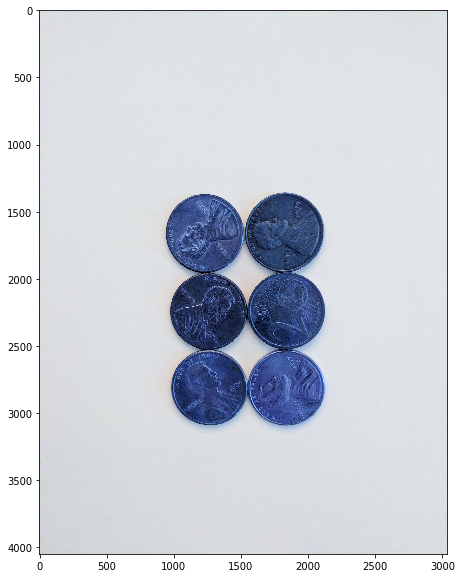

In [6]:
display(coins)

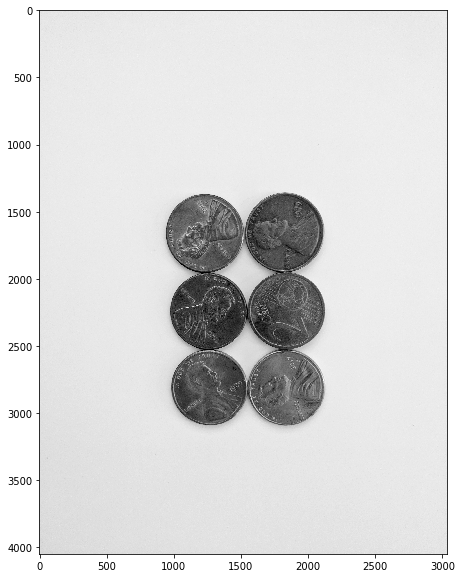

In [7]:
gray_coins = cv.cvtColor(coins, cv.COLOR_BGR2GRAY)
display(gray_coins)

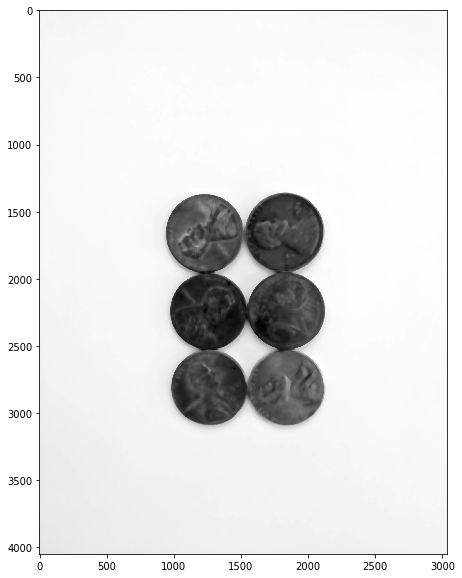

In [8]:
# Apply Blur
# Image is large so we need a large filter size
blurred_coins = cv.medianBlur(gray_coins, 25)
display(blurred_coins)

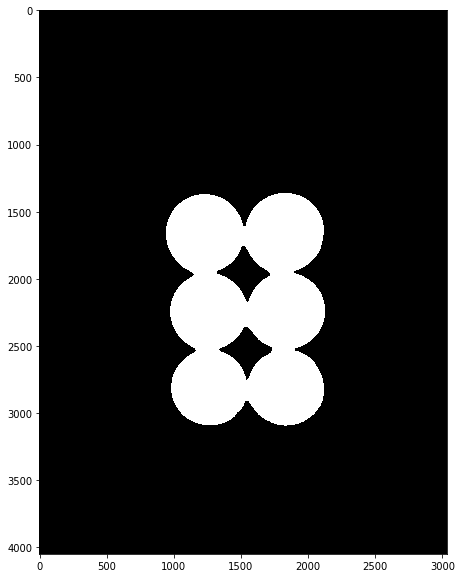

In [12]:
# Apply binary threshold but since we want black background
# we will use inverted binary threshold
ret, threshed_coins = cv.threshold(blurred_coins, 160, 255, cv.THRESH_BINARY_INV)
display(threshed_coins)

In [13]:
# Find Contours
img, contours, hierarchy= cv.findContours(threshed_coins.copy(), cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

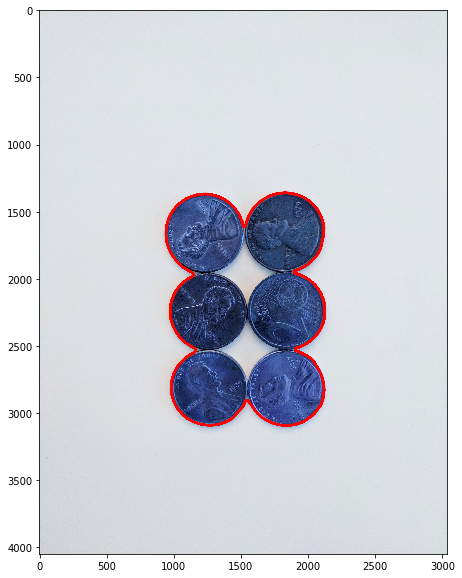

In [17]:
# Need to find external contours
for i in range(len(contours)):
    if hierarchy[0][i][-1] == -1:
        cv.drawContours(coins, contours, i, (255, 0, 0), 20, cv.LINE_AA)
        
display(coins)

As we can see from the image above we find only the outline of combined coins not the individual coins
This is why a better option here is to use watershed algorithm

-> Lets try the watershed algorithm

Steps are: <br>
<ol>
    <li> Apply median blur </li>
    <li> Convert to grayscale </li>
    <li> Apply OTSU threshold </li>
    <li> Apply Noise reduction </li>
    <li> Dilate the image and denote as sure_background </li>
    <li> Apply "DISTANCE TRANSFORM" which brightens the image when we move towards the center of the image (Skeletization) </li>
    <li> Apply threshold again (creating seeds at the center of each coin) and denote as sure_foreground </li>
    <li> Subtract foreground from background and denote as "UNKNOWN" because these are the regions that maybe in either background or foreground </li>
    <li> Create a markers object using "connectedComponents" method, which labels the background and foreground points and increment each element by 1</li>
    <li> Make the pixels valued 255 in the unknown = 0 in the markers object </li>
    <li> Finally apply the watershed algorithm </li>
</ol>

In [2]:
pennies = cv.imread('DATA/pennies.jpg')
blurred_pennies = cv.medianBlur(pennies, 35)
gray_pennies = cv.cvtColor(blurred_pennies, cv.COLOR_BGR2GRAY)

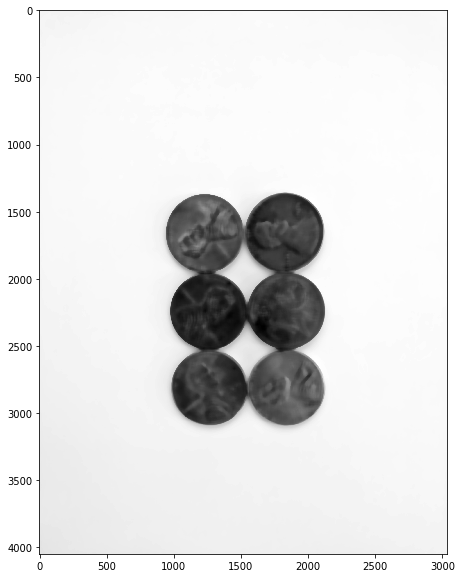

In [5]:
display(gray_pennies)

In [6]:
ret, thresh_pennies = cv.threshold(gray_pennies, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

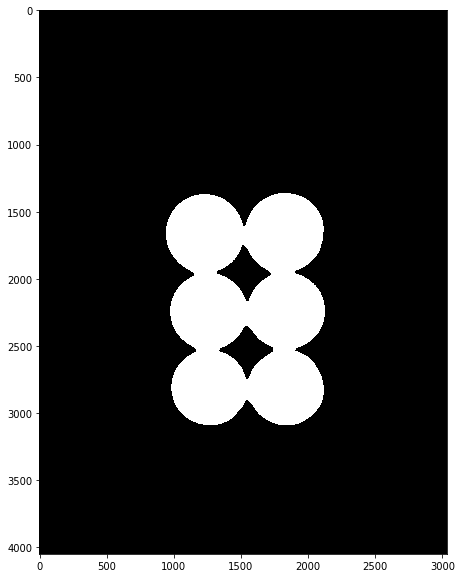

In [7]:
display(thresh_pennies)

In [8]:
kernel = np.ones((3,3), np.uint8)

In [10]:
opening = cv.morphologyEx(thresh_pennies, cv.MORPH_OPEN, kernel, iterations=2)

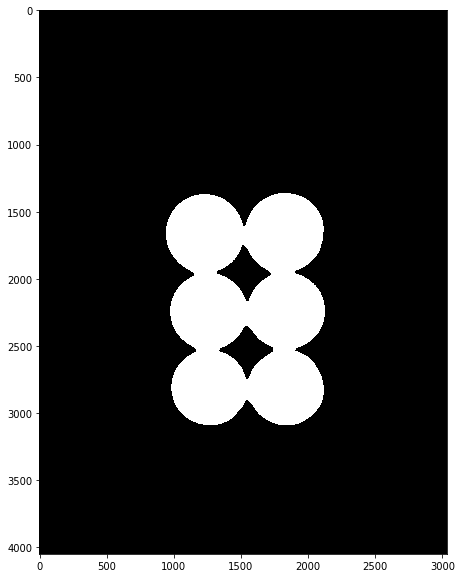

In [11]:
display(opening)

In [12]:
sure_background = cv.dilate(opening, kernel, iterations = 3)

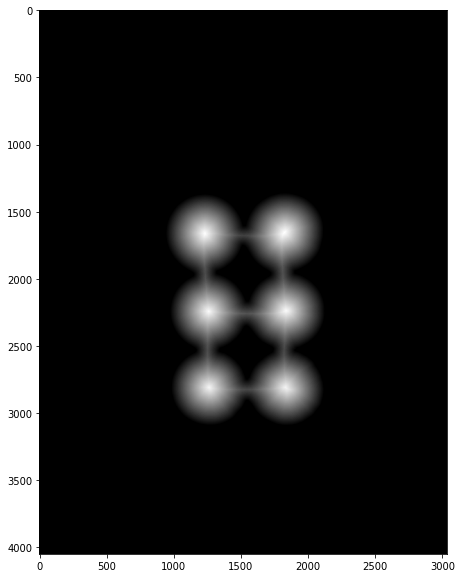

In [20]:
dist_trans = cv.distanceTransform(opening, cv.DIST_L2, 5)
display(dist_trans)

In [21]:
ret, sure_foreground = cv.threshold(dist_trans, 0.7*dist_trans.max(), 255, cv.THRESH_BINARY)

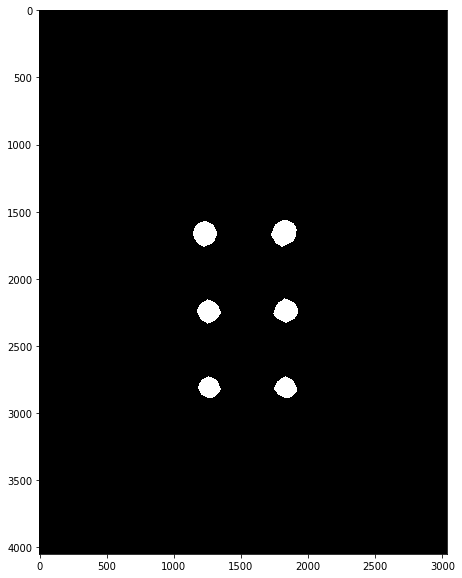

In [22]:
display(sure_foreground)

In [23]:
sure_foreground = np.uint8(sure_foreground)

In [24]:
unknown = np.subtract(sure_background, sure_foreground)

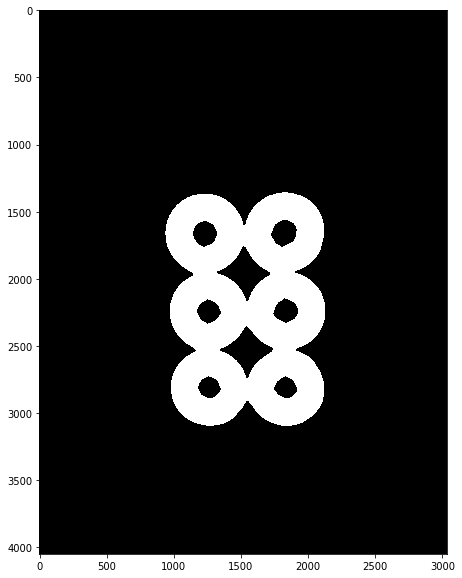

In [25]:
display(unknown)

In [26]:
ret, markers = cv.connectedComponents(sure_foreground)

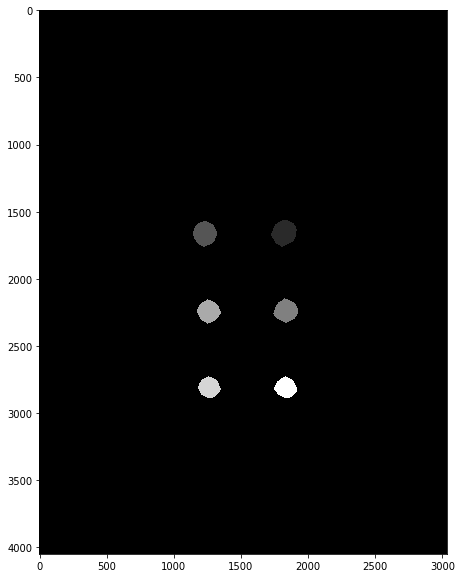

In [27]:
display(markers)

In [29]:
markers = markers + 1

In [31]:
markers[unknown==255] = 0

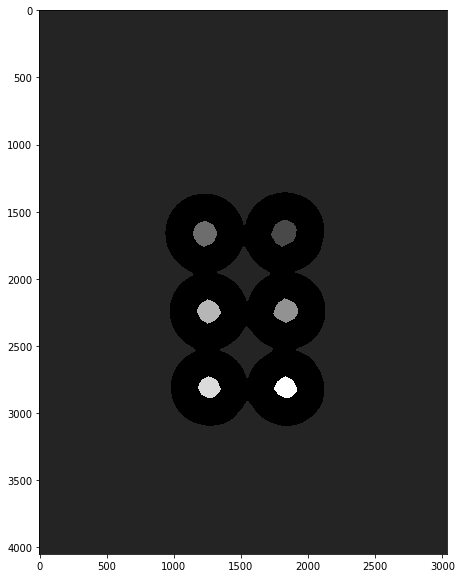

In [32]:
display(markers)

In [33]:
markers = cv.watershed(pennies, markers)

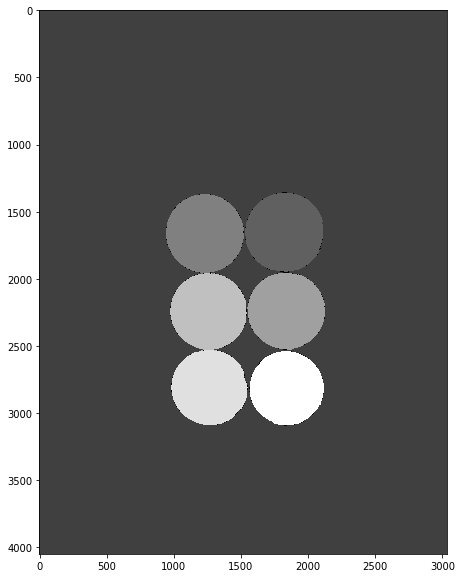

In [34]:
display(markers)

In [35]:
img, contours, hierarchy = cv.findContours(markers.copy(), cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

In [36]:
for i in range(len(contours)):
    if hierarchy[0][i][-1] == -1:
        cv.drawContours(pennies, contours, i, (255, 0, 0), 5)

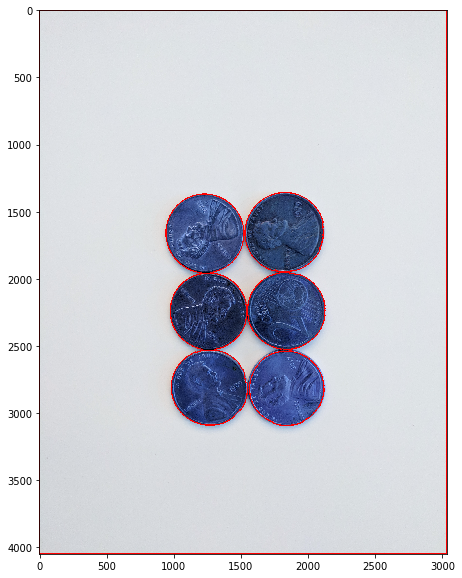

In [37]:
display(pennies)